In [1]:
import os
import sys
if not os.getcwd().endswith("Submodular"):
    sys.path.append('../Submodular')    

In [2]:
import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

In [3]:
from ipynb.fs.full.Dataset import get_data
from ipynb.fs.full.Dataset import datasets as available_datasets
from ipynb.fs.full.Utils import save_plot

In [4]:
import argparse
from argparse import ArgumentParser

#set default arguments here
def get_configuration():
    parser = ArgumentParser()
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--log_info', type=bool, default=True)
    parser.add_argument('--pbar', type=bool, default=False)
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--learning_rate', type=float, default=0.01)
    parser.add_argument('--num_gpus', type=int, default=-1)
    parser.add_argument('--parallel_mode', type=str, default="dp", choices=['dp', 'ddp', 'ddp2'])
    parser.add_argument('--dataset', type=str, default="Cora", choices=available_datasets)
    #parser.add_argument('--use_normalization', action='store_false', default=True)
    parser.add_argument('--use_normalization', action='store_true')    
    parser.add_argument('-f') ##dummy for jupyternotebook
    
    args = parser.parse_args()
    
    dict_args = vars(args)
    
    return args, dict_args

args, dict_args = get_configuration()

## Packages

In [5]:
import torch.nn as nn
import numpy as np
from torch.nn import init
from random import shuffle, randint
import torch.nn.functional as F
from itertools import combinations, combinations_with_replacement
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import sys
from torch_geometric.data import Data
import logging
import time

import argparse
import os.path as osp
import math

In [6]:
import random
import numpy as np
import torch

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
None

### GSAINT model

In [7]:
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel
from tqdm import tqdm

from torch_geometric.loader import NeighborSampler, NeighborLoader
from torch_geometric.loader import GraphSAINTRandomWalkSampler, GraphSAINTNodeSampler, GraphSAINTEdgeSampler, GraphSAINTSampler
from ipynb.fs.full.a2AGS_Graph_Sampler import AGSGraphSampler

from torch_geometric.nn import GraphConv
from torch_geometric.utils import degree

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
# from torch_geometric.nn.models import MLP
from torch_geometric.nn.conv.gcn_conv import gcn_norm
import numpy as np
import scipy.sparse
from tqdm import tqdm

In [9]:
class MLP(nn.Module):
    """ adapted from https://github.com/CUAI/CorrectAndSmooth/blob/master/gen_models.py """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout=.5):
        super(MLP, self).__init__()
        self.lins = nn.ModuleList()
        self.bns = nn.ModuleList()
        if num_layers == 1:
            # just linear layer i.e. logistic regression
            self.lins.append(nn.Linear(in_channels, out_channels))
        else:
            self.lins.append(nn.Linear(in_channels, hidden_channels))
            self.bns.append(nn.BatchNorm1d(hidden_channels))
            for _ in range(num_layers - 2):
                self.lins.append(nn.Linear(hidden_channels, hidden_channels))
                self.bns.append(nn.BatchNorm1d(hidden_channels))
            self.lins.append(nn.Linear(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, b_data, input_tensor=False):
        if not input_tensor:
            x = b_data.x.shape[1]
        else:
            x = b_data
        for i, lin in enumerate(self.lins[:-1]):
            x = lin(x)
            x = F.relu(x, inplace=True)
            x = self.bns[i](x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return x

In [10]:
class LINKX(nn.Module):	
    """ our LINKX method with skip connections 
        a = MLP_1(A), x = MLP_2(X), MLP_3(sigma(W_1[a, x] + a + x))
    """

    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, num_nodes, dropout=.5, cache=False, inner_activation=False, inner_dropout=False, init_layers_A=1, init_layers_X=1):
        super(LINKX, self).__init__()	
        self.mlpA = MLP(num_nodes, hidden_channels, hidden_channels, init_layers_A, dropout=0)
        self.mlpX = MLP(in_channels, hidden_channels, hidden_channels, init_layers_X, dropout=0)
        self.W = nn.Linear(2*hidden_channels, hidden_channels)
        self.mlp_final = MLP(hidden_channels, hidden_channels, out_channels, num_layers, dropout=dropout)
        self.in_channels = in_channels
        self.num_nodes = num_nodes
        self.A = None
        self.inner_activation = inner_activation
        self.inner_dropout = inner_dropout

    def reset_parameters(self):	
        self.mlpA.reset_parameters()	
        self.mlpX.reset_parameters()
        self.W.reset_parameters()
        self.mlp_final.reset_parameters()	

    def forward(self, b_data):	
        
        m = b_data.num_nodes
        feat_dim = b_data.x.shape[1]
        row, col = b_data.edge_index
        
        row = row-row.min()
        A = SparseTensor(row=row, col=col,	
                 sparse_sizes=(m, self.num_nodes)
                        ).to_torch_sparse_coo_tensor()

        xA = self.mlpA(A, input_tensor=True)
        xX = self.mlpX(b_data.x, input_tensor=True)
        x = torch.cat((xA, xX), axis=-1)
        x = self.W(x)
        if self.inner_dropout:
            x = F.dropout(x)
        if self.inner_activation:
            x = F.relu(x)
        x = F.relu(x + xA + xX)
        x = self.mlp_final(x, input_tensor=True)
        
        x.log_softmax(dim=-1)
        
        return x

In [11]:
def test(model, loader, mask, name='Train'):
    if args.log_info:
        pbar = tqdm(total=sum(mask).item())
        pbar.set_description(f'Evaluating {name}')

    model.eval()
    
    total_correct=0
    total_examples=0
    
    with torch.no_grad():                  
    
        for i,batch_data in enumerate(loader):
            out = model(batch_data.to(device))
            out=out[:batch_data.batch_size,:]
            pred = out.argmax(dim=-1)            
            correct = pred.eq(batch_data.y[:batch_data.batch_size].to(device))

            total_correct+=correct.sum()
            total_examples+=batch_data.batch_size

            if args.log_info:                
                pbar.update(batch_data.batch_size)
    if args.log_info:
        pbar.close()

    return total_correct.item()/total_examples

In [12]:
def train(DATASET_NAME, model, data, dataset, epochs=10,train_neighbors=[8,4],test_neighbors=[8,4]):
        
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    
    row, col = data.edge_index
    data.edge_weight = 1. / degree(col, data.num_nodes)[col]  # Norm by in-degree.

    
    sampler_dir = DIR+'AGSLINKX/'+DATASET_NAME
    if not os.path.exists(sampler_dir):
        os.makedirs(sampler_dir)
        
    batch_size=min(data.num_nodes,4096)
    #batch_size= 6000
    
    num_steps=math.ceil(data.num_nodes/batch_size) #num_steps=5    
    num_workers = 0 if data.num_nodes <100000 else 8
    
    worker = num_workers
    
    sample_func =['rw']
    weight_func =[
        {'exact':True,'weight':'knn'}, #exact for exact size to the batch
       #{'exact':False,'weight':'knn'}
    ]

    params={'knn':{'metric':'cosine'},
            'submodular':{'metric':'cosine'},
            'link-nn':{'value':'min'},
            'link-sub':{'value':'max'},
            'disjoint':{'value':'mst'},
           }
    
    loader = AGSGraphSampler(
        data, batch_size=batch_size, walk_length=2, num_steps=num_steps, sample_coverage=100,
        num_workers=num_workers,log=args.log_info,save_dir=sampler_dir,recompute = False, shuffle = False,
        sample_func = sample_func, weight_func=weight_func, params=params)
        
#     #### original loader
#     loader = GraphSAINTRandomWalkSampler(data, batch_size=batch_size, walk_length=2,
#                                      num_steps=num_steps, sample_coverage=100,
#                                      save_dir=sampler_dir,num_workers=num_workers)
    
#     #----
    
    if args.log_info:
        print("Train neighbors: ", train_neighbors)
        print("Test neighbors: ", test_neighbors)

    sample_batch_size=512
    train_loader = NeighborLoader(data, input_nodes=data.train_mask,num_neighbors=train_neighbors, 
                            batch_size=sample_batch_size, shuffle=False, num_workers=num_workers)
    val_loader = NeighborLoader(data,input_nodes=data.val_mask,num_neighbors=test_neighbors, 
                                batch_size=sample_batch_size,shuffle=False, num_workers=num_workers)
    test_loader = NeighborLoader(data, input_nodes=data.test_mask,num_neighbors=test_neighbors, 
                                 batch_size=sample_batch_size,shuffle=False, num_workers=num_workers)

#         subgraph_loader = NeighborSampler(data.edge_index, node_idx=None,
#                                       sizes=[-1], batch_size=2048,
#                                       shuffle=False, num_workers=4)

    
    best_acc=0    
    num_iteration = epochs
    train_losses = []; val_accuracies = []; train_accuracies = []; test_accuracies = [];
    training_times = []
    
    for epoch in range(1,epochs+1):
        if args.log_info:
            #pbar = tqdm(total=int(sum(data.train_mask)))
            pbar = tqdm(total=batch_size*num_steps)
            pbar.set_description(f'Epoch {epoch:02d}')
        
        model.train()

        total_loss = total_examples = 0
        
        epoch_start = time.time()
        
        for i,batch_data in enumerate(loader):
            
            #print(batch_data);print("*"*50)            
            batch_data = batch_data.to(device)
            optimizer.zero_grad()

            if args.use_normalization:
#                 edge_weight = batch_data.edge_norm * batch_data.edge_weight
                out = model(batch_data)
                loss = F.nll_loss(out, batch_data.y, reduction='none')
                #loss = criterion(out, batch_data.y, reduction='none')
                loss = (loss * batch_data.node_norm)[batch_data.train_mask].sum()
            else:
                out = model(batch_data)
                loss = F.nll_loss(out[batch_data.train_mask], batch_data.y[batch_data.train_mask])
                #loss = criterion(out[batch_data.train_mask], batch_data.y[batch_data.train_mask])

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_data.num_nodes
            total_examples += batch_data.num_nodes
            
            if args.log_info:
                pbar.update(batch_size)
        
        if args.log_info:
            pbar.close()
        
        epoch_end = time.time()
        training_times.append(epoch_end-epoch_start)
        
        loss=total_loss / total_examples
        train_losses.append(loss)
        
        if args.log_info:
            print("Training Loss: ",loss)                             
        
        if data.num_nodes<10000:
            model.eval()
            
            with torch.no_grad():
                out = model(batch_data.to(device))
                pred = out.argmax(dim=-1)
                correct = pred.eq(data.y.to(device))

            accs = []
            for _, mask in data('train_mask', 'val_mask', 'test_mask'):
                accs.append(correct[mask].sum().item() / mask.sum().item())
            
            if args.log_info:                
                print(accs)

            if accs[2]>best_acc:
                best_acc=accs[2]
                
            train_acc=accs[0]
            val_acc=accs[1]
            test_acc=accs[2]

        else:
            if args.log_info==True:
                train_acc=test(model, train_loader,data.train_mask,'Train')
                val_acc = test(model, val_loader,data.val_mask,'Validation')
            else:
                train_acc=0
                val_acc = 0            
            test_acc = test(model, test_loader,data.test_mask,'Test')
            
            accs=[train_acc,val_acc,test_acc]
            
            if args.log_info:
                print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

            if test_acc>best_acc:
                best_acc=test_acc
                
        train_accuracies.append(accs[0])
        val_accuracies.append(accs[1])
        test_accuracies.append(accs[2])
        std_dev = np.std(train_losses[-5:])
        
                
        std_dev = np.std(train_losses[-5:])
        if args.log_info:
            print('std_dev: ', std_dev)
        
        if epoch>=5 and std_dev<=1e-3:
            num_iteration = epoch            
            if args.log_info:                
                print("Iteration for convergence: ", epoch)
            break
            
    if args.log_info:
        save_plot([train_losses, train_accuracies, val_accuracies, test_accuracies], labels=['Loss','Train','Validation','Test'], name='Results/AGSGSValidation', yname='Accuracy', xname='Epoch')
        print ("Best Validation Accuracy, ",max(val_accuracies))
        print ("Best Test Accuracy, ",max(test_accuracies))
    
    acc_file = open("Runtime/AGSLINKX.txt",'a+') 
    acc_file.write(str(train_losses))
    acc_file.write(str(train_accuracies))
    acc_file.write(str(val_accuracies))
    acc_file.write(str(test_accuracies))
    acc_file.write(str(training_times))
    acc_file.write(str(np.mean(training_times)))
    acc_file.write(f'\nworker {worker:1d} avg epoch runtime {np.mean(training_times):0.8f}')
    acc_file.close()     
 
                
    return best_acc, num_iteration

In [13]:
def LINKXperformance(DATASET_NAME, data, dataset, num_classes, epochs=20, train_neighbors=[8,4],test_neighbors=[8,4]):
    
    model  = LINKX(in_channels=data.x.shape[1], hidden_channels=32, out_channels=num_classes, num_layers=2, num_nodes = data.num_nodes).to(device)
    
    if args.log_info:
        print(model)
    
    best_acc, num_iteration = train(DATASET_NAME, model, data, dataset, epochs, train_neighbors, test_neighbors)
    
    return best_acc, num_iteration, model

In [14]:
from sklearn.decomposition import TruncatedSVD
import numpy as np

def adj_feature(data):    
    adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
    edges = data.edge_index.t()
    adj_mat[edges[:,0], edges[:,1]] = 1
    adj_mat[edges[:,1], edges[:,0]] = 1
    
#     n_components = data.x.shape[1]
    n_components = min(256, data.x.shape[1], data.num_nodes)

    svd = TruncatedSVD(n_components=n_components)
    x = svd.fit_transform(adj_mat)
    
    x = torch.Tensor(x)
    x.shape    
    
    return x

# x = adj_feature(data)
# x.shape

In [15]:
# # Define your adjacency matrix (replace this with your actual adjacency matrix)
# adj = np.array([[0, 1, 0, 1],
#                 [1, 0, 1, 0],
#                 [0, 1, 0, 1],
#                 [1, 0, 1, 0]], dtype=np.float32)

# n_components = 2

# # Perform SVD dimensionality reduction
# svd = TruncatedSVD(n_components=n_components)
# low_dimensional_matrix = svd.fit_transform(adj_feature(data))

# low_dimensional_matrix.shape


N  2708  E  10556  d  3.8980797636632203 0.825157880783081 0.8099659085273743 0.7657181620597839 -0.06587088108062744 
LINKX(
  (mlpA): MLP(
    (lins): ModuleList(
      (0): Linear(in_features=2708, out_features=32, bias=True)
    )
    (bns): ModuleList()
  )
  (mlpX): MLP(
    (lins): ModuleList(
      (0): Linear(in_features=1433, out_features=32, bias=True)
    )
    (bns): ModuleList()
  )
  (W): Linear(in_features=64, out_features=32, bias=True)
  (mlp_final): MLP(
    (lins): ModuleList(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=7, bias=True)
    )
    (bns): ModuleList(
      (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
)
loading saved norm
Loading weights  knn
Train neighbors:  [8, 4]
Test neighbors:  [8, 4]


Epoch 01: 100%|██████████| 2708/2708 [00:00<00:00, 92404.49it/s]


Training Loss:  -0.10447314381599426
[0.14285714285714285, 0.114, 0.103]
std_dev:  0.0


Epoch 02: 100%|██████████| 2708/2708 [00:00<00:00, 265613.75it/s]


Training Loss:  -0.08582159876823425
[0.14285714285714285, 0.114, 0.103]
std_dev:  0.009325772523880005


Epoch 03: 100%|██████████| 2708/2708 [00:00<00:00, 249526.03it/s]


Training Loss:  0.013879459351301193
[0.14285714285714285, 0.114, 0.103]
std_dev:  0.05195673392277562


Epoch 04: 100%|██████████| 2708/2708 [00:00<00:00, 278960.98it/s]


Training Loss:  -0.0345785915851593
[0.14285714285714285, 0.114, 0.103]
std_dev:  0.04620254099923314


Epoch 05: 100%|██████████| 2708/2708 [00:00<00:00, 268261.11it/s]


Training Loss:  -0.08721710741519928
[0.14285714285714285, 0.114, 0.103]
std_dev:  0.043564133924128584


Epoch 06: 100%|██████████| 2708/2708 [00:00<00:00, 275824.45it/s]


Training Loss:  -0.22158314287662506
[0.14285714285714285, 0.114, 0.103]
std_dev:  0.07869088223600282


Epoch 07: 100%|██████████| 2708/2708 [00:00<00:00, 282485.46it/s]


Training Loss:  -0.18939246237277985
[0.14285714285714285, 0.114, 0.103]
std_dev:  0.08957006964835271


Epoch 08: 100%|██████████| 2708/2708 [00:00<00:00, 292925.22it/s]


Training Loss:  -0.25322532653808594
[0.14285714285714285, 0.114, 0.104]
std_dev:  0.08286859732244223


Epoch 09: 100%|██████████| 2708/2708 [00:00<00:00, 298962.29it/s]


Training Loss:  -0.20738746225833893
[0.14285714285714285, 0.114, 0.104]
std_dev:  0.056296439341168285


Epoch 10: 100%|██████████| 2708/2708 [00:00<00:00, 283232.14it/s]


Training Loss:  -0.23224371671676636
[0.14285714285714285, 0.114, 0.104]
std_dev:  0.0216762437579846


Epoch 11: 100%|██████████| 2708/2708 [00:00<00:00, 303743.25it/s]


Training Loss:  -0.3763292133808136
[0.14285714285714285, 0.114, 0.104]
std_dev:  0.06596839157047424


Epoch 12: 100%|██████████| 2708/2708 [00:00<00:00, 296767.31it/s]


Training Loss:  -0.4092433452606201
[0.14285714285714285, 0.114, 0.103]
std_dev:  0.08126876693194361


Epoch 13: 100%|██████████| 2708/2708 [00:00<00:00, 287986.19it/s]


Training Loss:  -0.3378898501396179
[0.14285714285714285, 0.114, 0.104]
std_dev:  0.079457830263338


Epoch 14: 100%|██████████| 2708/2708 [00:00<00:00, 285008.91it/s]


Training Loss:  -0.5236639380455017
[0.14285714285714285, 0.116, 0.102]
std_dev:  0.09489788209067142


Epoch 15: 100%|██████████| 2708/2708 [00:00<00:00, 286822.61it/s]


Training Loss:  -0.5417753458023071
[0.14285714285714285, 0.114, 0.103]
std_dev:  0.08094401107078023


Epoch 16: 100%|██████████| 2708/2708 [00:00<00:00, 290758.12it/s]


Training Loss:  -0.6456629037857056
[0.14285714285714285, 0.114, 0.102]
std_dev:  0.10741550860204356


Epoch 17: 100%|██████████| 2708/2708 [00:00<00:00, 293265.56it/s]


Training Loss:  -0.6843809485435486
[0.14285714285714285, 0.116, 0.104]
std_dev:  0.12075287801548128


Epoch 18: 100%|██████████| 2708/2708 [00:00<00:00, 292435.00it/s]


Training Loss:  -0.7171745896339417
[0.14285714285714285, 0.114, 0.104]
std_dev:  0.07695983600465198


Epoch 19: 100%|██████████| 2708/2708 [00:00<00:00, 294428.68it/s]


Training Loss:  -0.7934120297431946
[0.14285714285714285, 0.116, 0.102]
std_dev:  0.08305011916675191


Epoch 20: 100%|██████████| 2708/2708 [00:00<00:00, 281568.09it/s]


Training Loss:  -0.8098955750465393
[0.14285714285714285, 0.116, 0.104]
std_dev:  0.06286917827971836


Epoch 21: 100%|██████████| 2708/2708 [00:00<00:00, 291781.42it/s]


Training Loss:  -0.8592830896377563
[0.14285714285714285, 0.114, 0.102]
std_dev:  0.06354899356168596


Epoch 22: 100%|██████████| 2708/2708 [00:00<00:00, 286092.93it/s]


Training Loss:  -1.0884946584701538
[0.14285714285714285, 0.112, 0.102]
std_dev:  0.12597805022249806


Epoch 23: 100%|██████████| 2708/2708 [00:00<00:00, 273328.73it/s]


Training Loss:  -0.7686460614204407
[0.14285714285714285, 0.116, 0.104]
std_dev:  0.11612270272818956


Epoch 24: 100%|██████████| 2708/2708 [00:00<00:00, 294543.21it/s]


Training Loss:  -1.014623761177063
[0.14285714285714285, 0.112, 0.103]
std_dev:  0.12277141852022941


Epoch 25: 100%|██████████| 2708/2708 [00:00<00:00, 294604.33it/s]


Training Loss:  -1.010221004486084
[0.14285714285714285, 0.112, 0.102]
std_dev:  0.11669372872858266


Epoch 26: 100%|██████████| 2708/2708 [00:00<00:00, 292427.47it/s]


Training Loss:  -1.1519454717636108
[0.14285714285714285, 0.112, 0.104]
std_dev:  0.13002418022372905


Epoch 27: 100%|██████████| 2708/2708 [00:00<00:00, 273381.36it/s]


Training Loss:  -1.3931758403778076
[0.15, 0.114, 0.106]
std_dev:  0.20424788855706555


Epoch 28: 100%|██████████| 2708/2708 [00:00<00:00, 291138.22it/s]


Training Loss:  -1.3357208967208862
[0.14285714285714285, 0.112, 0.101]
std_dev:  0.15915258873169016


Epoch 29: 100%|██████████| 2708/2708 [00:00<00:00, 287374.13it/s]


Training Loss:  -1.4037131071090698
[0.15, 0.12, 0.108]
std_dev:  0.153741852546553


Epoch 30: 100%|██████████| 2708/2708 [00:00<00:00, 292457.59it/s]


Training Loss:  -1.5377074480056763
[0.1357142857142857, 0.114, 0.104]
std_dev:  0.1251946042274328


Epoch 31: 100%|██████████| 2708/2708 [00:00<00:00, 289623.77it/s]


Training Loss:  -1.690678596496582
[0.14285714285714285, 0.11, 0.11]
std_dev:  0.12773874964291035


Epoch 32: 100%|██████████| 2708/2708 [00:00<00:00, 292224.33it/s]


Training Loss:  -1.4449286460876465
[0.16428571428571428, 0.11, 0.103]
std_dev:  0.12292214143142663


Epoch 33: 100%|██████████| 2708/2708 [00:00<00:00, 293295.85it/s]


Training Loss:  -1.7489067316055298
[0.15, 0.126, 0.11]
std_dev:  0.1347531789022387


Epoch 34: 100%|██████████| 2708/2708 [00:00<00:00, 286323.71it/s]


Training Loss:  -1.7440638542175293
[0.15, 0.108, 0.117]
std_dev:  0.12128276454622026


Epoch 35: 100%|██████████| 2708/2708 [00:00<00:00, 286641.65it/s]


Training Loss:  -1.8686940670013428
[0.1357142857142857, 0.11, 0.114]
std_dev:  0.1399556897916729


Epoch 36: 100%|██████████| 2708/2708 [00:00<00:00, 292472.65it/s]


Training Loss:  -2.0794432163238525
[0.1357142857142857, 0.1, 0.111]
std_dev:  0.20592469092756605


Epoch 37: 100%|██████████| 2708/2708 [00:00<00:00, 288879.78it/s]


Training Loss:  -2.208707809448242
[0.15714285714285714, 0.126, 0.114]
std_dev:  0.18500635164493526


Epoch 38: 100%|██████████| 2708/2708 [00:00<00:00, 270053.38it/s]


Training Loss:  -2.1826181411743164
[0.19285714285714287, 0.156, 0.138]
std_dev:  0.18142147816489895


Epoch 39: 100%|██████████| 2708/2708 [00:00<00:00, 295278.30it/s]


Training Loss:  -2.257180690765381
[0.12142857142857143, 0.124, 0.143]
std_dev:  0.13813465965811225


Epoch 40: 100%|██████████| 2708/2708 [00:00<00:00, 292502.77it/s]


Training Loss:  -2.4167251586914062
[0.17142857142857143, 0.116, 0.12]
std_dev:  0.11042205104409944


Epoch 41: 100%|██████████| 2708/2708 [00:00<00:00, 290944.32it/s]


Training Loss:  -2.4714324474334717
[0.17142857142857143, 0.112, 0.133]
std_dev:  0.11549134285812845


Epoch 42: 100%|██████████| 2708/2708 [00:00<00:00, 271648.69it/s]


Training Loss:  -2.4943418502807617
[0.19285714285714287, 0.134, 0.143]
std_dev:  0.12297915121332548


Epoch 43: 100%|██████████| 2708/2708 [00:00<00:00, 293061.26it/s]


Training Loss:  -3.0062615871429443
[0.19285714285714287, 0.118, 0.132]
std_dev:  0.2525014980167901


Epoch 44: 100%|██████████| 2708/2708 [00:00<00:00, 293470.15it/s]


Training Loss:  -2.897359609603882
[0.15714285714285714, 0.096, 0.133]
std_dev:  0.24428718206706168


Epoch 45: 100%|██████████| 2708/2708 [00:00<00:00, 291392.17it/s]


Training Loss:  -3.0824599266052246
[0.16428571428571428, 0.124, 0.116]
std_dev:  0.25796368234462047


Epoch 46: 100%|██████████| 2708/2708 [00:00<00:00, 291571.69it/s]


Training Loss:  -3.2470695972442627
[0.19285714285714287, 0.11, 0.138]
std_dev:  0.2526877073323686


Epoch 47: 100%|██████████| 2708/2708 [00:00<00:00, 273664.59it/s]


Training Loss:  -3.1462881565093994
[0.19285714285714287, 0.106, 0.128]
std_dev:  0.11918283016900307


Epoch 48: 100%|██████████| 2708/2708 [00:00<00:00, 287076.34it/s]


Training Loss:  -3.2759344577789307
[0.15, 0.118, 0.135]
std_dev:  0.13538752721891562


Epoch 49: 100%|██████████| 2708/2708 [00:00<00:00, 292759.11it/s]


Training Loss:  -3.4522252082824707
[0.17857142857142858, 0.118, 0.138]
std_dev:  0.1264740479073304


Epoch 50: 100%|██████████| 2708/2708 [00:00<00:00, 273079.01it/s]


Training Loss:  -3.719203233718872
[0.16428571428571428, 0.134, 0.155]
std_dev:  0.20134242530358076


Epoch 51: 100%|██████████| 2708/2708 [00:00<00:00, 295032.86it/s]


Training Loss:  -3.8670105934143066
[0.18571428571428572, 0.122, 0.144]
std_dev:  0.2683420199485439


Epoch 52: 100%|██████████| 2708/2708 [00:00<00:00, 287119.88it/s]


Training Loss:  -3.9684629440307617
[0.2, 0.128, 0.167]
std_dev:  0.25773070586410246


Epoch 53: 100%|██████████| 2708/2708 [00:00<00:00, 288835.70it/s]


Training Loss:  -3.953047037124634
[0.17142857142857143, 0.13, 0.156]
std_dev:  0.1915453918290967


Epoch 54: 100%|██████████| 2708/2708 [00:00<00:00, 288139.61it/s]


Training Loss:  -4.1629414558410645
[0.17142857142857143, 0.148, 0.165]
std_dev:  0.1446304374752293


Epoch 55: 100%|██████████| 2708/2708 [00:00<00:00, 292435.00it/s]


Training Loss:  -4.521286487579346
[0.17142857142857143, 0.176, 0.19]
std_dev:  0.23429751889341238


Epoch 56: 100%|██████████| 2708/2708 [00:00<00:00, 269393.65it/s]


Training Loss:  -4.843640327453613
[0.17857142857142858, 0.168, 0.163]
std_dev:  0.3444062210243213


Epoch 57: 100%|██████████| 2708/2708 [00:00<00:00, 244830.47it/s]


Training Loss:  -4.580977439880371
[0.2, 0.184, 0.176]
std_dev:  0.3160625089731322


Epoch 58: 100%|██████████| 2708/2708 [00:00<00:00, 292789.30it/s]


Training Loss:  -4.783341884613037
[0.14285714285714285, 0.188, 0.191]
std_dev:  0.24009498068475416


Epoch 59: 100%|██████████| 2708/2708 [00:00<00:00, 297911.54it/s]


Training Loss:  -4.759803295135498
[0.14285714285714285, 0.182, 0.18]
std_dev:  0.12428656715334171


Epoch 60: 100%|██████████| 2708/2708 [00:00<00:00, 289993.50it/s]


Training Loss:  -5.3753838539123535
[0.17142857142857143, 0.192, 0.196]
std_dev:  0.26806165777606233


Epoch 61: 100%|██████████| 2708/2708 [00:00<00:00, 297420.07it/s]


Training Loss:  -5.554967403411865
[0.17142857142857143, 0.21, 0.195]
std_dev:  0.38171284438796177


Epoch 62: 100%|██████████| 2708/2708 [00:00<00:00, 296055.66it/s]


Training Loss:  -5.69307279586792
[0.17857142857142858, 0.182, 0.184]
std_dev:  0.3903101838133387


Epoch 63: 100%|██████████| 2708/2708 [00:00<00:00, 286417.57it/s]


Training Loss:  -5.20971155166626
[0.11428571428571428, 0.186, 0.215]
std_dev:  0.3235534827836834


Epoch 64: 100%|██████████| 2708/2708 [00:00<00:00, 295978.51it/s]


Training Loss:  -5.794029235839844
[0.12857142857142856, 0.214, 0.229]
std_dev:  0.2113357987802573


Epoch 65: 100%|██████████| 2708/2708 [00:00<00:00, 290430.99it/s]


Training Loss:  -5.718504905700684
[0.15714285714285714, 0.214, 0.232]
std_dev:  0.20713750234448494


Epoch 66: 100%|██████████| 2708/2708 [00:00<00:00, 294611.97it/s]


Training Loss:  -6.5621256828308105
[0.18571428571428572, 0.232, 0.249]
std_dev:  0.4352665351238003


Epoch 67: 100%|██████████| 2708/2708 [00:00<00:00, 273552.55it/s]


Training Loss:  -6.385224342346191
[0.16428571428571428, 0.23, 0.235]
std_dev:  0.48760003173606264


Epoch 68: 100%|██████████| 2708/2708 [00:00<00:00, 304084.79it/s]


Training Loss:  -6.397919178009033
[0.17857142857142858, 0.244, 0.223]
std_dev:  0.3456069668336938


Epoch 69: 100%|██████████| 2708/2708 [00:00<00:00, 275136.26it/s]


Training Loss:  -6.759185314178467
[0.11428571428571428, 0.234, 0.241]
std_dev:  0.3503393689586864


Epoch 70: 100%|██████████| 2708/2708 [00:00<00:00, 296713.04it/s]


Training Loss:  -6.795901775360107
[0.15714285714285714, 0.246, 0.243]
std_dev:  0.17328092901275985


Epoch 71: 100%|██████████| 2708/2708 [00:00<00:00, 279585.85it/s]


Training Loss:  -6.921358108520508
[0.08571428571428572, 0.24, 0.235]
std_dev:  0.21930639978933217


Epoch 72: 100%|██████████| 2708/2708 [00:00<00:00, 293606.70it/s]


Training Loss:  -6.710286617279053
[0.1357142857142857, 0.24, 0.234]
std_dev:  0.17414071523584176


Epoch 73: 100%|██████████| 2708/2708 [00:00<00:00, 300107.68it/s]


Training Loss:  -7.6307220458984375
[0.10714285714285714, 0.236, 0.219]
std_dev:  0.34085535643682924


Epoch 74: 100%|██████████| 2708/2708 [00:00<00:00, 276590.17it/s]


Training Loss:  -7.337201118469238
[0.10714285714285714, 0.216, 0.232]
std_dev:  0.3498600059260837


Epoch 75: 100%|██████████| 2708/2708 [00:00<00:00, 294253.24it/s]


Training Loss:  -7.139853000640869
[0.14285714285714285, 0.23, 0.227]
std_dev:  0.3199510886800877


Epoch 76: 100%|██████████| 2708/2708 [00:00<00:00, 304174.37it/s]


Training Loss:  -7.701308727264404
[0.12142857142857143, 0.244, 0.234]
std_dev:  0.35920567187187835


Epoch 77: 100%|██████████| 2708/2708 [00:00<00:00, 299569.44it/s]


Training Loss:  -7.833904266357422
[0.1357142857142857, 0.228, 0.238]
std_dev:  0.25346623961634973


Epoch 78: 100%|██████████| 2708/2708 [00:00<00:00, 273592.08it/s]


Training Loss:  -8.12182903289795
[0.10714285714285714, 0.242, 0.254]
std_dev:  0.35056593146334664


Epoch 79: 100%|██████████| 2708/2708 [00:00<00:00, 301629.89it/s]


Training Loss:  -8.776068687438965
[0.1357142857142857, 0.252, 0.263]
std_dev:  0.536154838217388


Epoch 80: 100%|██████████| 2708/2708 [00:00<00:00, 294215.13it/s]


Training Loss:  -8.674227714538574
[0.07857142857142857, 0.268, 0.269]
std_dev:  0.4343437629411276


Epoch 81: 100%|██████████| 2708/2708 [00:00<00:00, 273230.10it/s]


Training Loss:  -9.714618682861328
[0.18571428571428572, 0.252, 0.254]
std_dev:  0.6467648235415069


Epoch 82: 100%|██████████| 2708/2708 [00:00<00:00, 298020.97it/s]


Training Loss:  -8.98974609375
[0.11428571428571428, 0.246, 0.249]
std_dev:  0.5164394996229442


Epoch 83: 100%|██████████| 2708/2708 [00:00<00:00, 292089.06it/s]


Training Loss:  -8.672684669494629
[0.09285714285714286, 0.25, 0.248]
std_dev:  0.3919773599474722


Epoch 84: 100%|██████████| 2708/2708 [00:00<00:00, 280608.13it/s]


Training Loss:  -9.57900619506836
[0.1, 0.264, 0.235]
std_dev:  0.44268378426959415


Epoch 85: 100%|██████████| 2708/2708 [00:00<00:00, 292706.30it/s]


Training Loss:  -8.911829948425293
[0.17857142857142858, 0.228, 0.226]
std_dev:  0.4025661144872918


Epoch 86: 100%|██████████| 2708/2708 [00:00<00:00, 305105.84it/s]


Training Loss:  -9.172887802124023
[0.1, 0.204, 0.198]
std_dev:  0.30294468584218937


Epoch 87: 100%|██████████| 2708/2708 [00:00<00:00, 294306.62it/s]


Training Loss:  -9.486105918884277
[0.14285714285714285, 0.166, 0.202]
std_dev:  0.3408931158813701


Epoch 88: 100%|██████████| 2708/2708 [00:00<00:00, 300918.67it/s]


Training Loss:  -9.795394897460938
[0.1357142857142857, 0.162, 0.19]
std_dev:  0.31147534618842854


Epoch 89: 100%|██████████| 2708/2708 [00:00<00:00, 304712.95it/s]


Training Loss:  -10.22164535522461
[0.19285714285714287, 0.166, 0.172]
std_dev:  0.4603532546772912


Epoch 90: 100%|██████████| 2708/2708 [00:00<00:00, 291056.15it/s]


Training Loss:  -9.74476432800293
[0.15, 0.144, 0.163]
std_dev:  0.34801185998000256


Epoch 91: 100%|██████████| 2708/2708 [00:00<00:00, 286706.77it/s]


Training Loss:  -11.200347900390625
[0.17142857142857143, 0.182, 0.147]
std_dev:  0.6034683504025491


Epoch 92: 100%|██████████| 2708/2708 [00:00<00:00, 306927.94it/s]


Training Loss:  -10.594610214233398
[0.12142857142857143, 0.16, 0.156]
std_dev:  0.5414479717714347


Epoch 93: 100%|██████████| 2708/2708 [00:00<00:00, 303727.01it/s]


Training Loss:  -11.36557674407959
[0.14285714285714285, 0.142, 0.167]
std_dev:  0.6029778952671014


Epoch 94: 100%|██████████| 2708/2708 [00:00<00:00, 303062.47it/s]


Training Loss:  -11.479792594909668
[0.17142857142857143, 0.146, 0.152]
std_dev:  0.6431674149680721


Epoch 95: 100%|██████████| 2708/2708 [00:00<00:00, 297817.80it/s]


Training Loss:  -11.792736053466797
[0.15714285714285714, 0.118, 0.158]
std_dev:  0.39649052874892005


Epoch 96: 100%|██████████| 2708/2708 [00:00<00:00, 281400.67it/s]


Training Loss:  -12.169478416442871
[0.12142857142857143, 0.184, 0.154]
std_dev:  0.5234866111722789


Epoch 97: 100%|██████████| 2708/2708 [00:00<00:00, 294680.76it/s]


Training Loss:  -12.210323333740234
[0.11428571428571428, 0.126, 0.151]
std_dev:  0.34528959374870916


Epoch 98: 100%|██████████| 2708/2708 [00:00<00:00, 280428.00it/s]


Training Loss:  -12.65176010131836
[0.17142857142857143, 0.126, 0.147]
std_dev:  0.39820345288463804


Epoch 99: 100%|██████████| 2708/2708 [00:00<00:00, 295309.01it/s]


Training Loss:  -11.687650680541992
[0.12142857142857143, 0.126, 0.152]
std_dev:  0.3423016909345662


Epoch 100: 100%|██████████| 2708/2708 [00:00<00:00, 268660.86it/s]


Training Loss:  -13.043615341186523
[0.06428571428571428, 0.152, 0.141]
std_dev:  0.46107108424288423


Epoch 101: 100%|██████████| 2708/2708 [00:00<00:00, 296503.91it/s]


Training Loss:  -12.247502326965332
[0.14285714285714285, 0.134, 0.149]
std_dev:  0.45590186575977365


Epoch 102: 100%|██████████| 2708/2708 [00:00<00:00, 293530.82it/s]


Training Loss:  -12.991074562072754
[0.16428571428571428, 0.16, 0.167]
std_dev:  0.5060458529111032


Epoch 103: 100%|██████████| 2708/2708 [00:00<00:00, 292352.20it/s]


Training Loss:  -14.662474632263184
[0.14285714285714285, 0.162, 0.192]
std_dev:  1.0027242163944554


Epoch 104: 100%|██████████| 2708/2708 [00:00<00:00, 295785.81it/s]


Training Loss:  -13.088491439819336
[0.12857142857142856, 0.16, 0.163]
std_dev:  0.790747005263539


Epoch 105: 100%|██████████| 2708/2708 [00:00<00:00, 277841.86it/s]


Training Loss:  -13.561440467834473
[0.1357142857142857, 0.19, 0.188]
std_dev:  0.7965036759172216


Epoch 106: 100%|██████████| 2708/2708 [00:00<00:00, 294078.02it/s]


Training Loss:  -14.180228233337402
[0.19285714285714287, 0.182, 0.168]
std_dev:  0.6407246267097766


Epoch 107: 100%|██████████| 2708/2708 [00:00<00:00, 288578.86it/s]


Training Loss:  -14.229084968566895
[0.09285714285714286, 0.18, 0.177]
std_dev:  0.5534490248297359


Epoch 108: 100%|██████████| 2708/2708 [00:00<00:00, 291407.12it/s]


Training Loss:  -14.9847993850708
[0.1357142857142857, 0.176, 0.177]
std_dev:  0.6446062833676839


Epoch 109: 100%|██████████| 2708/2708 [00:00<00:00, 271499.35it/s]


Training Loss:  -15.275996208190918
[0.12142857142857143, 0.152, 0.162]
std_dev:  0.6130791680822772


Epoch 110: 100%|██████████| 2708/2708 [00:00<00:00, 298091.36it/s]


Training Loss:  -14.751870155334473
[0.1357142857142857, 0.162, 0.152]
std_dev:  0.4257414788384245


Epoch 111: 100%|██████████| 2708/2708 [00:00<00:00, 285668.39it/s]


Training Loss:  -14.630796432495117
[0.20714285714285716, 0.138, 0.127]
std_dev:  0.35053235498104857


Epoch 112: 100%|██████████| 2708/2708 [00:00<00:00, 288879.78it/s]


Training Loss:  -14.05681037902832
[0.12857142857142856, 0.138, 0.152]
std_dev:  0.4064561568521667


Epoch 113: 100%|██████████| 2708/2708 [00:00<00:00, 287214.26it/s]


Training Loss:  -14.859305381774902
[0.15714285714285714, 0.16, 0.139]
std_dev:  0.39425981415715017


Epoch 114: 100%|██████████| 2708/2708 [00:00<00:00, 285862.51it/s]


Training Loss:  -16.025711059570312
[0.15, 0.168, 0.144]
std_dev:  0.6431333730091956


Epoch 115: 100%|██████████| 2708/2708 [00:00<00:00, 294344.75it/s]


Training Loss:  -15.587749481201172
[0.12142857142857143, 0.138, 0.131]
std_dev:  0.6982981682025283


Epoch 116: 100%|██████████| 2708/2708 [00:00<00:00, 291833.90it/s]


Training Loss:  -16.09608268737793
[0.15, 0.144, 0.157]
std_dev:  0.7719816183019423


Epoch 117: 100%|██████████| 2708/2708 [00:00<00:00, 291721.46it/s]


Training Loss:  -16.61261749267578
[0.17142857142857143, 0.164, 0.154]
std_dev:  0.5869119674686185


Epoch 118: 100%|██████████| 2708/2708 [00:00<00:00, 291369.74it/s]


Training Loss:  -15.4801607131958
[0.15, 0.17, 0.136]
std_dev:  0.4043664538499336


Epoch 119: 100%|██████████| 2708/2708 [00:00<00:00, 272914.97it/s]


Training Loss:  -16.81685447692871
[0.16428571428571428, 0.148, 0.149]
std_dev:  0.5332028844661386


Epoch 120: 100%|██████████| 2708/2708 [00:00<00:00, 297373.35it/s]


Training Loss:  -16.905176162719727
[0.14285714285714285, 0.15, 0.144]
std_dev:  0.5312360663933684


Epoch 121: 100%|██████████| 2708/2708 [00:00<00:00, 294039.95it/s]


Training Loss:  -17.280975341796875
[0.15714285714285714, 0.168, 0.14]
std_dev:  0.6093028931287463


Epoch 122: 100%|██████████| 2708/2708 [00:00<00:00, 292427.47it/s]


Training Loss:  -18.334848403930664
[0.15, 0.154, 0.147]
std_dev:  0.9172337764992797


Epoch 123: 100%|██████████| 2708/2708 [00:00<00:00, 290907.06it/s]


Training Loss:  -18.024290084838867
[0.22142857142857142, 0.152, 0.138]
std_dev:  0.6060571136745487


Epoch 124: 100%|██████████| 2708/2708 [00:00<00:00, 290735.79it/s]


Training Loss:  -17.151018142700195
[0.15, 0.138, 0.136]
std_dev:  0.5454759589161166


Epoch 125: 100%|██████████| 2708/2708 [00:00<00:00, 273625.04it/s]


Training Loss:  -19.193025588989258
[0.2, 0.14, 0.138]
std_dev:  0.7448140673189746


Epoch 126: 100%|██████████| 2708/2708 [00:00<00:00, 300123.54it/s]


Training Loss:  -18.25599479675293
[0.17857142857142858, 0.138, 0.142]
std_dev:  0.6539606926626169


Epoch 127: 100%|██████████| 2708/2708 [00:00<00:00, 291586.66it/s]


Training Loss:  -19.2493953704834
[0.17142857142857143, 0.148, 0.131]
std_dev:  0.7834569640397384


Epoch 128: 100%|██████████| 2708/2708 [00:00<00:00, 291586.66it/s]


Training Loss:  -18.177581787109375
[0.17857142857142858, 0.152, 0.149]
std_dev:  0.7720594731733764


Epoch 129: 100%|██████████| 2708/2708 [00:00<00:00, 289564.70it/s]


Training Loss:  -19.012155532836914
[0.15714285714285714, 0.132, 0.149]
std_dev:  0.4652481980082162


Epoch 130: 100%|██████████| 2708/2708 [00:00<00:00, 268318.14it/s]


Training Loss:  -18.805423736572266
[0.16428571428571428, 0.116, 0.122]
std_dev:  0.4196312340431603


Epoch 131: 100%|██████████| 2708/2708 [00:00<00:00, 288659.53it/s]


Training Loss:  -18.934370040893555
[0.17142857142857143, 0.134, 0.133]
std_dev:  0.35945858996235264


Epoch 132: 100%|██████████| 2708/2708 [00:00<00:00, 294001.90it/s]


Training Loss:  -19.282020568847656
[0.22142857142857142, 0.132, 0.127]
std_dev:  0.367121814647993


Epoch 133: 100%|██████████| 2708/2708 [00:00<00:00, 268998.09it/s]


Training Loss:  -20.087608337402344
[0.18571428571428572, 0.146, 0.131]
std_dev:  0.4589455149517175


Epoch 134: 100%|██████████| 2708/2708 [00:00<00:00, 305952.36it/s]


Training Loss:  -19.63761329650879
[0.14285714285714285, 0.118, 0.125]
std_dev:  0.4691947321330433


Epoch 135: 100%|██████████| 2708/2708 [00:00<00:00, 298005.33it/s]


Training Loss:  -19.406190872192383
[0.1357142857142857, 0.116, 0.137]
std_dev:  0.3836249821780985


Epoch 136: 100%|██████████| 2708/2708 [00:00<00:00, 288205.41it/s]


Training Loss:  -20.507930755615234
[0.19285714285714287, 0.122, 0.134]
std_dev:  0.4544019240216537


Epoch 137: 100%|██████████| 2708/2708 [00:00<00:00, 287381.40it/s]


Training Loss:  -20.603757858276367
[0.16428571428571428, 0.156, 0.119]
std_dev:  0.4695330013830818


Epoch 138: 100%|██████████| 2708/2708 [00:00<00:00, 289166.61it/s]


Training Loss:  -20.327388763427734
[0.17857142857142858, 0.156, 0.116]
std_dev:  0.4831147052174067


Epoch 139: 100%|██████████| 2708/2708 [00:00<00:00, 289328.66it/s]


Training Loss:  -20.795454025268555
[0.14285714285714285, 0.148, 0.138]
std_dev:  0.4851109308891376


Epoch 140: 100%|██████████| 2708/2708 [00:00<00:00, 272888.74it/s]


Training Loss:  -22.006423950195312
[0.17857142857142858, 0.128, 0.144]
std_dev:  0.5985055254084589


Epoch 141: 100%|██████████| 2708/2708 [00:00<00:00, 295462.65it/s]


Training Loss:  -22.6265926361084
[0.10714285714285714, 0.132, 0.118]
std_dev:  0.8877199708674159


Epoch 142: 100%|██████████| 2708/2708 [00:00<00:00, 307726.23it/s]


Training Loss:  -22.613496780395508
[0.15714285714285714, 0.13, 0.137]
std_dev:  0.9471850276136407


Epoch 143: 100%|██████████| 2708/2708 [00:00<00:00, 291991.45it/s]


Training Loss:  -23.399858474731445
[0.14285714285714285, 0.134, 0.119]
std_dev:  0.8676174602737803


Epoch 144: 100%|██████████| 2708/2708 [00:00<00:00, 287410.49it/s]


Training Loss:  -22.849992752075195
[0.15, 0.122, 0.129]
std_dev:  0.44860143825685


Epoch 145: 100%|██████████| 2708/2708 [00:00<00:00, 294291.36it/s]


Training Loss:  -22.94580078125
[0.15714285714285714, 0.122, 0.136]
std_dev:  0.28651938145241174


Epoch 146: 100%|██████████| 2708/2708 [00:00<00:00, 287898.59it/s]


Training Loss:  -22.86722755432129
[0.09285714285714286, 0.12, 0.13]
std_dev:  0.25744643573001647


Epoch 147: 100%|██████████| 2708/2708 [00:00<00:00, 283154.47it/s]


Training Loss:  -23.517728805541992
[0.1357142857142857, 0.148, 0.124]
std_dev:  0.2841045415326405


Epoch 148: 100%|██████████| 2708/2708 [00:00<00:00, 264660.62it/s]


Training Loss:  -23.288068771362305
[0.15714285714285714, 0.152, 0.137]
std_dev:  0.26462683051817726


Epoch 149: 100%|██████████| 2708/2708 [00:00<00:00, 294268.49it/s]


Training Loss:  -22.7796630859375
[0.17142857142857143, 0.152, 0.133]
std_dev:  0.2787050304870994


Epoch 150: 100%|██████████| 2708/2708 [00:00<00:00, 295885.98it/s]


Training Loss:  -23.377161026000977
[0.12857142857142856, 0.13, 0.134]
std_dev:  0.2904217958109664


<Figure size 432x288 with 0 Axes>

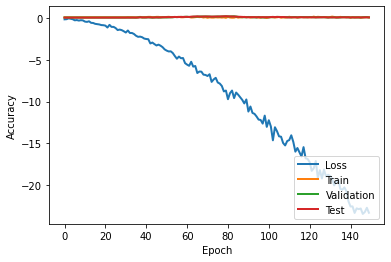

Best Validation Accuracy,  0.268
Best Test Accuracy,  0.269
0.269 150


In [16]:
# cornell5
# penn94
# johnshopkins55

args.log_info = True
DATASET_NAME = 'Cora'
data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=True, split_no=0); print("")

#if DATASET_NAME in ['Squirrel', 'Chameleon']:
# data.x = torch.cat((data.x, adj_feature(data)), dim=1)
# if args.log_info == True:
#     print(data.x.shape)

best_acc, num_iteration, _ = LINKXperformance(DATASET_NAME, data, dataset, dataset.num_classes, epochs=150,
                             train_neighbors=[8,4],test_neighbors=[8,4])    
print(best_acc, num_iteration)

# Batch Experiments

In [17]:
def batch_experiments(num_run=1):
    
    ALL_DATASETs= [
#         "Cornell",
        "Texas",
        "Wisconsin",
        "reed98",
        "amherst41",
        "penn94",
        "Roman-empire",
#         "cornell5",
        "Squirrel",
        "johnshopkins55",
        "AmazonProducts",
        "Actor",
        "Minesweeper",
        "Questions",
        "Chameleon",
        "Tolokers",
        "Flickr",
        "Yelp",
        "Amazon-ratings",
        "genius",
        "cora",
        "CiteSeer",
        "dblp",
        "Computers",
        "PubMed",
        "pubmed",
        "Reddit",
        "cora_ml",
        "Cora",
        "Reddit2",
        "CS",
        "Photo",
        "Physics",
        "citeseer"
    ]     
#     ALL_DATASETs= ["Cora"]
    
    args.log_info = False
    runtime_filename = "Runtime/AGSLINKX.txt"
    
    for DATASET_NAME in ALL_DATASETs:  
        print(DATASET_NAME, end=' ')        
        result_file = open("Results/AGSLINKX.txt",'a+')                
        result_file.write(f'{DATASET_NAME} ')
        
        acc_file = open(runtime_filename,'a+') 
        acc_file.write(f'{DATASET_NAME}\n')
        acc_file.close()     
        
        
        accs = []
        itrs = []
        
        for i in range(num_run):
            data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=False, split_no=i)       
                        
            if data.num_nodes>100000:
                accs.append(-1)
                itrs.append(-1)
                break         
                
            
            if len(data.y.shape) > 1:
                data.y = data.y.argmax(dim=1)        
                num_classes = torch.max(data.y).item()+1
            else:
                num_classes = dataset.num_classes
            
            if num_classes!= torch.max(data.y)+1:
                num_classes = torch.max(data.y).item()+1
            if data.num_nodes<100000:
                max_epochs = 150
            else:
                max_epochs = 20
                                
            accuracy, itr, _ = LINKXperformance(DATASET_NAME, data, dataset, num_classes, epochs=max_epochs,train_neighbors=[8,4],test_neighbors=[8,4])
            accs.append(accuracy)
            itrs.append(itr)
            #print(itr, accuracy)
                        
        #print(accs, itrs)
        print(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}')
        result_file.write(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}\n')
        result_file.close()

# start = time.time()
# batch_experiments(num_run = 1)
# end = time.time()

# print("Time spent:", end-start)